In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

In [2]:

adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')

In [3]:
adata.var_names_make_unique()
adata.raw = adata
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [4]:
adata_dis500 = adata.copy()

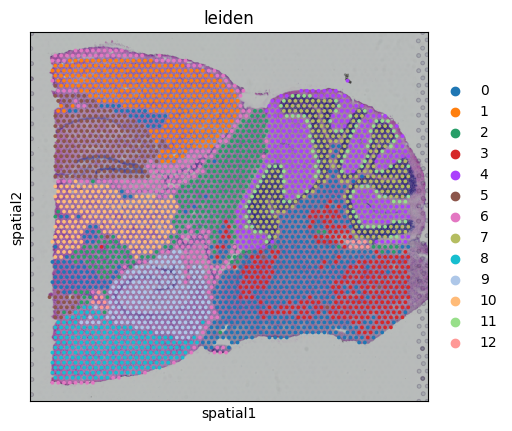

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4)
sc.pl.spatial(adata, color='leiden')

In [6]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)

(1209, 4)


In [7]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_dis500, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(250, 4)


In [8]:
print(df_cellchat_filtered.head())

       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling


In [ ]:
ct.tl.spatial_communication(adata_dis500,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [ ]:
adata_dis500.write("./adata.h5ad")


In [36]:
adata_dis500 = sc.read_h5ad('./adata.h5ad')

<Axes: >

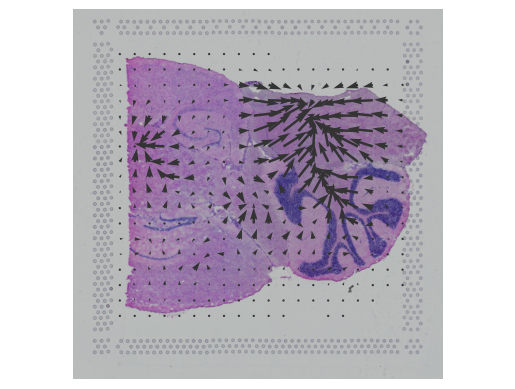

In [37]:
ct.tl.communication_direction(adata_dis500, database_name='cellchat', pathway_name='PSAP', k=5)
ct.pl.plot_cell_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

In [38]:
adata_dis500.obs['leiden'] = adata.obs['leiden']


In [39]:
ct.tl.cluster_communication(adata_dis500, database_name='cellchat', pathway_name='PSAP', clustering='leiden',
    n_permutations=100)

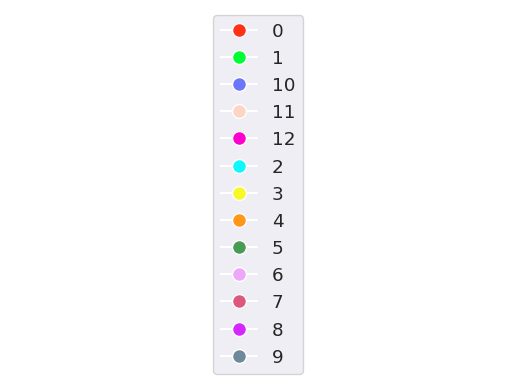

In [42]:
ct.pl.plot_cluster_communication_network(adata_dis500, uns_names=['commot_cluster-leiden-cellchat-PSAP'],
    nx_node_pos=None, nx_bg_pos=False, p_value_cutoff = 5e-2, filename='PSAP_cluster.pdf', nx_node_cmap='Light24')

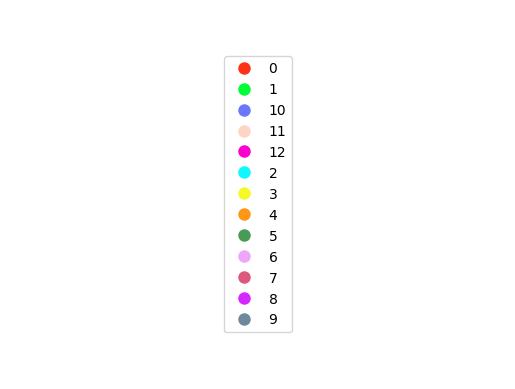

In [17]:
ct.tl.cluster_position(adata_dis500, clustering='leiden')
ct.pl.plot_cluster_communication_network(adata_dis500, uns_names=['commot_cluster-leiden-cellchat-PSAP'], clustering='leiden',
    nx_node_pos='cluster', nx_pos_idx=np.array([0, 1]), nx_bg_pos=True, nx_bg_ndsize=0.25, p_value_cutoff=5e-2,
    filename='PSAP_cluster_spatial.pdf', nx_node_cmap='Light24')

In [18]:
adata_dis500 = sc.read_h5ad("./adata.h5ad")
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata_dis500.layers['counts'] = adata.X

In [19]:
df_deg, df_yhat = ct.tl.communication_deg_detection(adata_dis500,
    database_name = 'cellchat', pathway_name='PSAP', summary = 'receiver')

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~25m 57s       |+                                                 | 2 % ~24m 41s       |++                                                | 3 % ~22m 58s       |++                                                | 4 % ~21m 40s       |+++                                               | 5 % ~20m 56s       |+++                                               | 6 % ~20m 34s       |++++                                              | 7 % ~20m 15s       |++++                                              | 8 % ~19m 59s       |+++++                                             | 9 % ~19m 42s       |+++++                                             | 10% ~19m 30s       |++++++                                            | 11% ~19m 04s       |++++++                                            | 12% ~18m 50s       |+++++++                                           | 13% ~18m 

In [20]:
import pickle
deg_result = {"df_deg": df_deg, "df_yhat": df_yhat}
with open('./deg_PSAP.pkl', 'wb') as handle:
    pickle.dump(deg_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

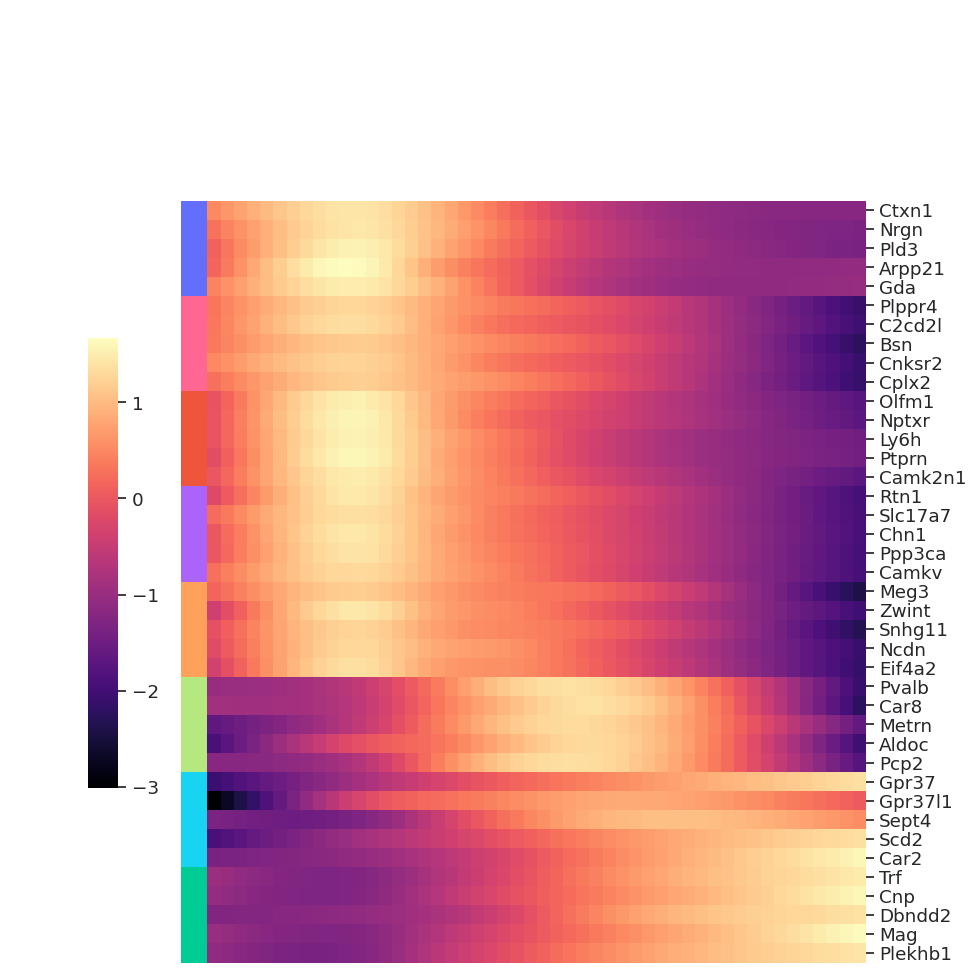

In [21]:
with open("./deg_PSAP.pkl", 'rb') as file:
    deg_result = pickle.load(file)
df_deg_clus, df_yhat_clus = ct.tl.communication_deg_clustering(df_deg, df_yhat, deg_clustering_res=0.4)
top_de_genes_PSAP = ct.pl.plot_communication_dependent_genes(df_deg_clus, df_yhat_clus, top_ngene_per_cluster=5,
    filename='./heatmap_deg_PSAP.pdf', font_scale=1.2, return_genes=True)

Text(0.5, 1.0, 'An example positive DE gene (Gpr37)')

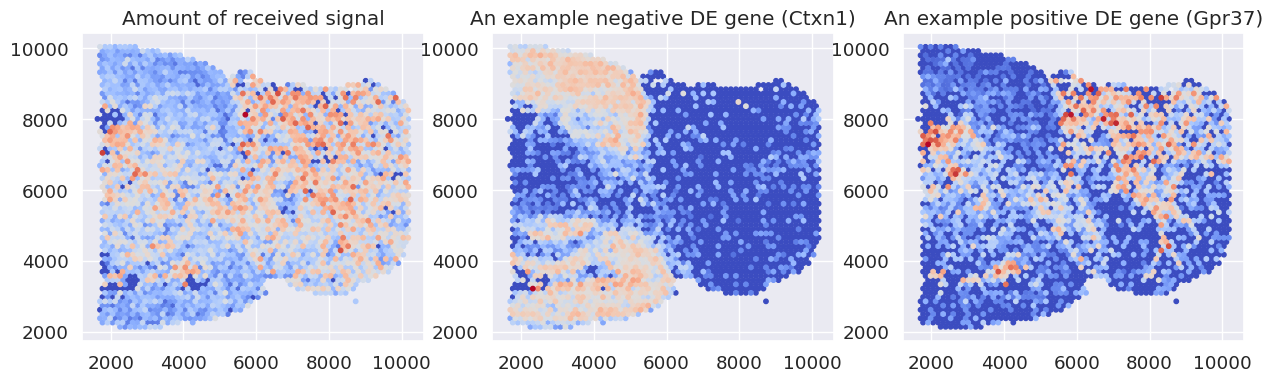

In [22]:
X_sc = adata_dis500.obsm['spatial']
fig, ax = plt.subplots(1,3, figsize=(15,4))
colors = adata_dis500.obsm['commot-cellchat-sum-receiver']['r-PSAP'].values
idx = np.argsort(colors)
ax[0].scatter(X_sc[idx,0],X_sc[idx,1], c=colors[idx], cmap='coolwarm', s=10)
colors = adata_dis500[:,'Ctxn1'].X.toarray().flatten()
idx = np.argsort(colors)
ax[1].scatter(X_sc[idx,0],X_sc[idx,1], c=colors[idx], cmap='coolwarm', s=10)
colors = adata_dis500[:,'Gpr37'].X.toarray().flatten()
idx = np.argsort(colors)
ax[2].scatter(X_sc[idx,0],X_sc[idx,1], c=colors[idx], cmap='coolwarm', s=10)
ax[0].set_title('Amount of received signal')
ax[1].set_title('An example negative DE gene (Ctxn1)')
ax[2].set_title('An example positive DE gene (Gpr37)')

In [23]:
df_impact_PSAP = ct.tl.communication_impact(adata_dis500, database_name='cellchat', pathway_name = 'PSAP',\
    tree_combined = True, method = 'treebased_score', tree_ntrees=100, tree_repeat = 100, tree_method = 'rf', \
    ds_genes = top_de_genes_PSAP, bg_genes = 500, normalize=True)

6 41
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


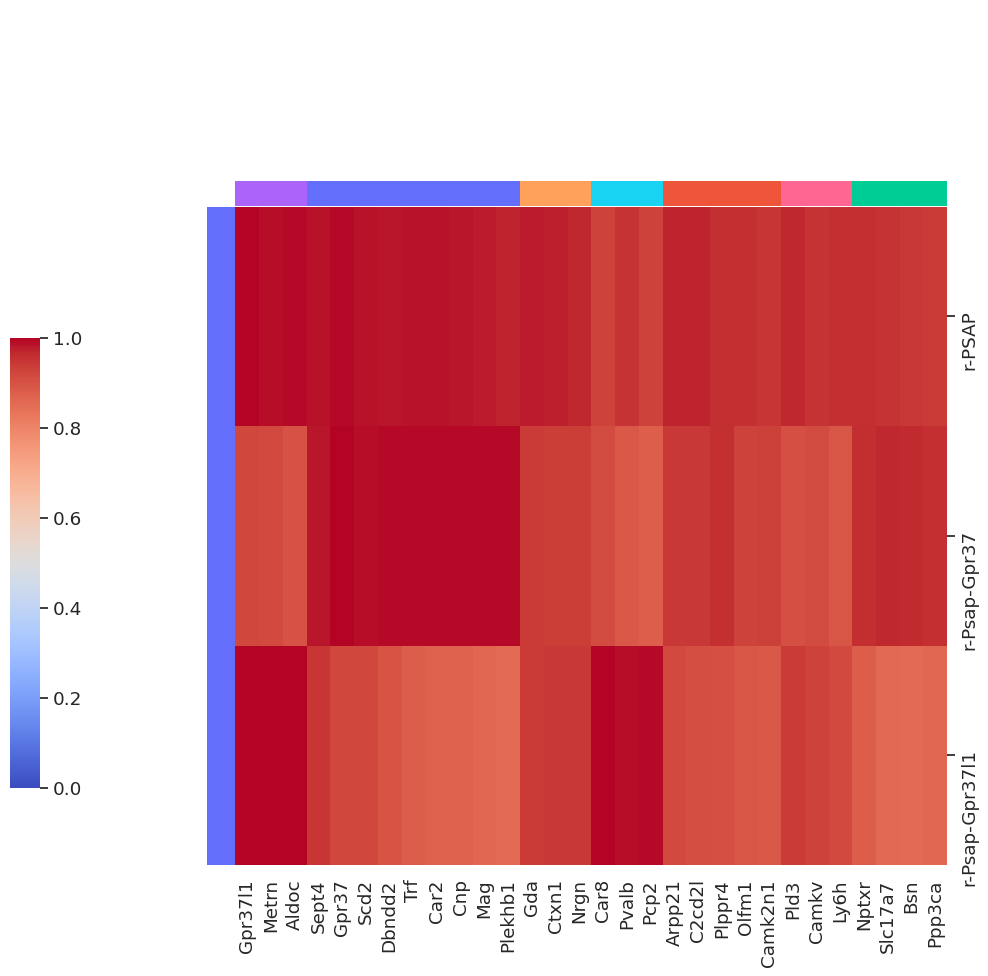

In [24]:
ct.pl.plot_communication_impact(df_impact_PSAP, summary = 'receiver', top_ngene= 30, top_ncomm = 5, colormap='coolwarm',
    font_scale=1.2, linewidth=0, show_gene_names=True, show_comm_names=True, cluster_knn=2,
    filename = 'heatmap_impact_PSAP.pdf')

In [25]:
df_impact_PSAP


,Ctxn1,Nrgn,Pld3,Arpp21,Gda,Plppr4,C2cd2l,Bsn,Cnksr2,Cplx2,...,Gpr37l1,Sept4,Scd2,Car2,Trf,Cnp,Dbndd2,Mag,Plekhb1,average
s-Psap-Gpr37l1,0.966956,0.966754,0.965141,0.951573,0.977278,0.947823,0.943427,0.887903,0.924040,0.849355,...,0.997641,0.966875,0.958790,0.943871,0.930141,0.928468,0.937923,0.935423,0.935746,0.978684
s-Psap-Gpr37,0.959294,0.962823,0.940907,0.965040,0.964456,0.979073,0.980202,0.981673,0.991919,0.993145,...,0.969234,0.986734,0.996008,0.997440,0.997939,0.996210,0.995363,0.996714,0.996875,0.972753
s-PSAP,0.992964,0.992581,0.990141,0.994012,0.994798,0.990403,0.994395,0.973871,0.992848,0.975040,...,0.993871,0.996673,0.994052,0.988165,0.993131,0.989556,0.989698,0.985524,0.989133,0.983462
r-Psap-Gpr37l1,0.943407,0.943468,0.939476,0.915161,0.940907,0.905625,0.907319,0.851653,0.799899,0.782419,...,0.999859,0.947964,0.921069,0.872883,0.882485,0.873911,0.895827,0.861774,0.853992,0.940142
r-Psap-Gpr37,0.933750,0.936069,0.906069,0.942722,0.937601,0.954274,0.942238,0.962117,0.976242,0.973669,...,0.920222,0.982218,0.991835,0.994617,0.994929,0.993528,0.992863,0.994214,0.993246,0.818178
r-PSAP,0.973690,0.965464,0.965060,0.969315,0.978004,0.956431,0.969173,0.941734,0.969091,0.945625,...,0.996431,0.987359,0.986794,0.985766,0.984606,0.981996,0.981956,0.977581,0.970363,0.950648
